# Giving the trend with Stocker and Prophet

This notebook shows a method to gives the trend of a given stock. It uses **a modified version of [Stocker](https://github.com/WillKoehrsen/Data-Analysis/tree/master/stocker)** to get any source data and clean it to create a time series. Then it uses [**Facebook Prophet**](https://facebook.github.io/prophet/) model which aims at 

>_forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects._ 

Yet, 

>_it works best with time series that have strong seasonal effects and several seasons of historical data_.

This raise the question of wether stocks have strong seasonal effects or not. I believe that most of the time they don't. However if for specific, seasonal, market they might have a seasonal effect. This is an open question.

Let's start by importing our tool, the modified version of Stocker :

In [1]:
import importlib
# Here you need the modified version of Stocker
from stocker import Stocker
import stocker
stocker.__file__

'C:\\Users\\antoi\\Documents\\Programming\\Luxurynsight\\Finance\\stocker.py'

In [2]:
# Command for plotting in the notebook
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Understanding : getting our own time series

We have just added a way to get the data from a given API in a new parameter `source`.
The modified constructor ass been designed to handle MSN Finance API which is used by Luxurynsight database. Here we will try to get the trend of _Gucci_

To-Do : try to implement it with Algolia which is the second Luxurynsight database.

In [3]:
gucci = Stocker('gucci',source = 'https://finance.services.appex.bing.com/Market.svc/ChartAndQuotes?symbols=160.1.KER.PAR&chartType=5y')

GUCCI Stocker Initialized. Data covers 2014-02-14 to 2019-02-08.


msci.plot_stock()


The Stocker object has a number of attributes and methods we can use for analysis and prediction. The main methods we will use in this notebook are `Stocker.create_prophet_model()`, `Stocker.changepoint_prior_analysis()`, `Stocker.changepoint_prior_validation()`, `Stocker.evaluate_prediction()`, and `Stocker.predict_future()`.

The most critical attributes for a forecast are `Stocker.changepoint_prior_scale`, `Stocker.training_years`, and the seasonalities included in the model.

### 1.1 Plot of stock history

Maximum Adj. Close = 512.00 on 2018-06-15.
Minimum Adj. Close = 137.35 on 2014-03-14.
Current Adj. Close = 439.80 on 2019-02-08.



C:\Users\antoi\Documents\Programming\Luxurynsight\Finance\stocker.py:232: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  trim_df = df[(df['Date'] >= start_date.date()) &
C:\Users\antoi\Documents\Programming\Luxurynsight\Finance\stocker.py:233: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  (df['Date'] <= end_date.date())]


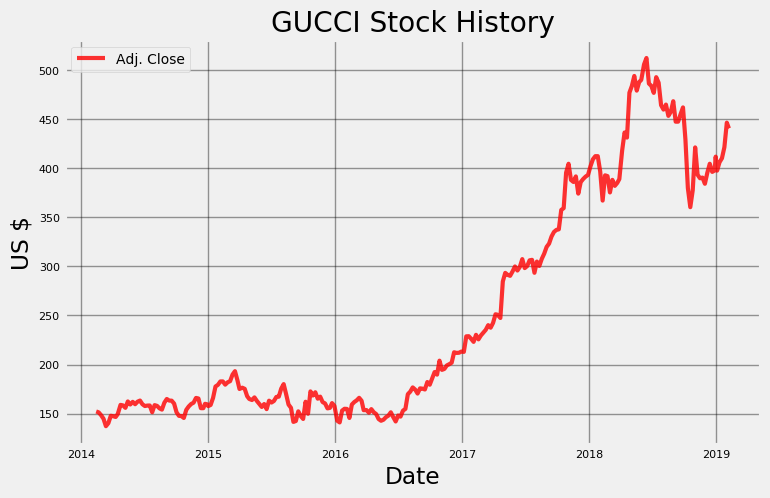

In [4]:
gucci.plot_stock()

We can also get the daily changes

### 1.2 Examine Trends/Patterns

We can create a basic model (with no predictions) trained on the past 3 years of data to inspect any trends and patterns in the data.

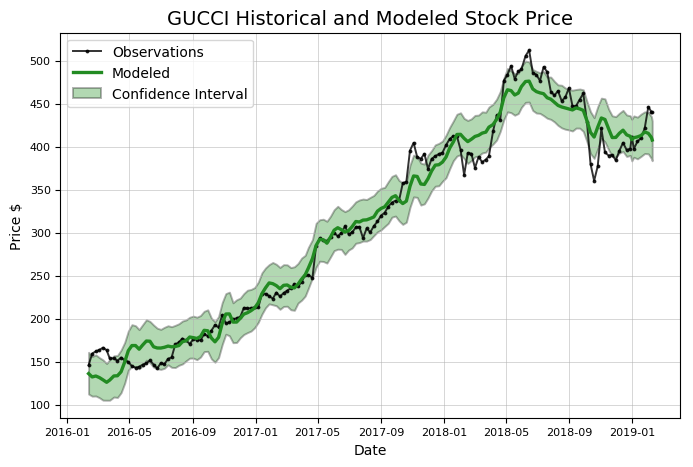

In [37]:
model, model_data = gucci.create_prophet_model()

Then we can isolate the trend and show the patterns that were learnt by the algorithm

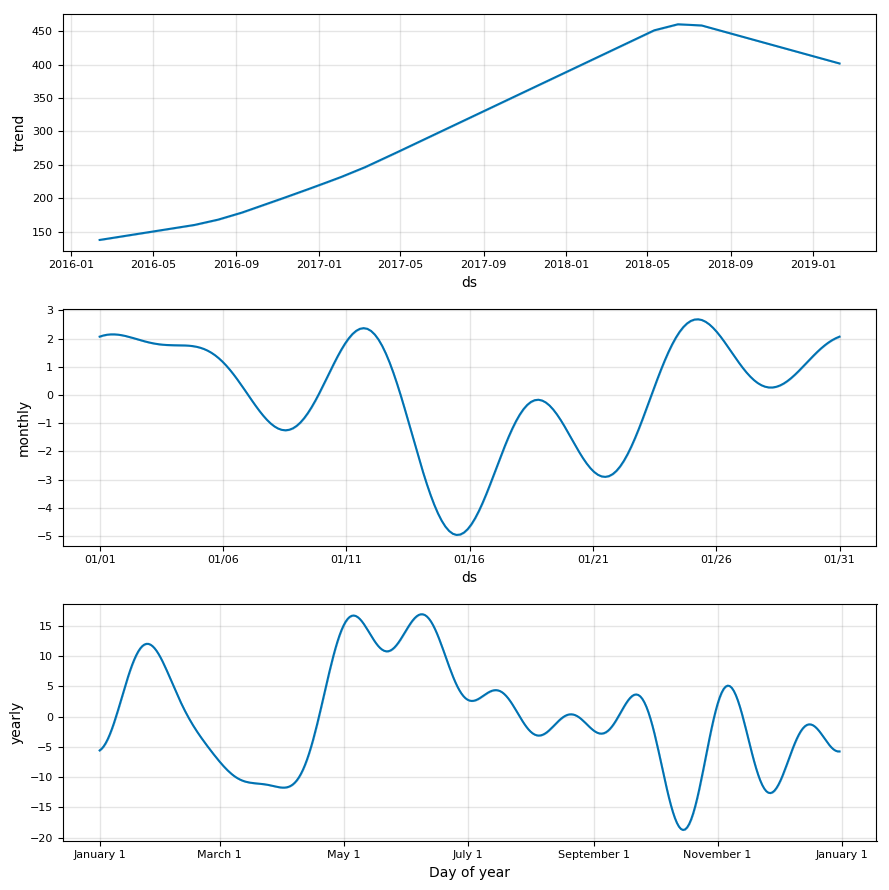

In [6]:
# Variables assigned from previous method call
model.plot_components(model_data)
plt.show()

## 2. Use : Prophet + days

Now we can create a Prophet model that will forcast the Stock time series for the next 30 days with `create_prophet_model(days=30)`

Predicted Price on 2019-03-10 = $383.60


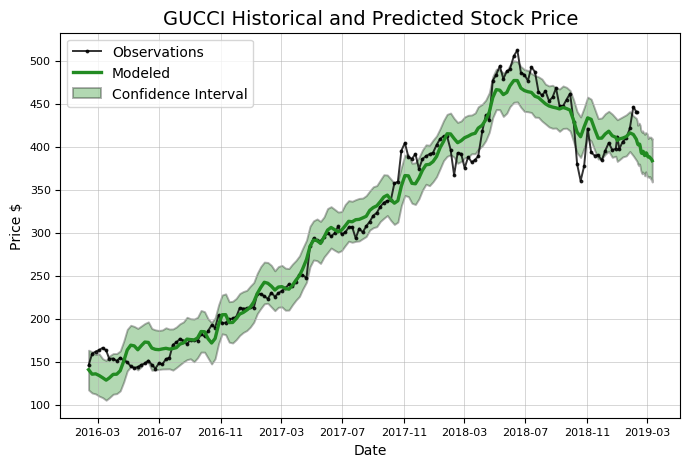

In [7]:
# predict days into the future
model, model_data = gucci.create_prophet_model(days=30)

### 2.1 Evaluate the model

We can also evaluate our model thanks to `evaluate_prediction(start_date, end_date)` that will print the how much time was the prediction with a confidence interval actually predicting the prices since `start_date` to `end_date`. **We must have data to be able to evaluate the method accucacy over the period.**

C:\Users\antoi\Documents\Programming\Luxurynsight\Finance\stocker.py:552: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  train = self.stock[(self.stock['Date'] < start_date.date()) &
C:\Users\antoi\Documents\Programming\Luxurynsight\Finance\stocker.py:553: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  (self.stock['Date'] > (start_date - pd.DateOffset(years=self.training_years)).date())]
C:\Users\antoi\Documents\Programming\Luxurynsight\Finance\stocker.py:556: FutureWarning: Comparing Series of datetimes 


Prediction Range: 2019-01-01 to 2019-02-08.

Predicted price on 2019-12-31 = $288.28.
Actual price on    2019-02-07 = $440.40.

Average Absolute Error on Training Data = $12.87.
Average Absolute Error on Testing  Data = $32.53.

When the model predicted an increase, the price increased nan% of the time.
When the model predicted a  decrease, the price decreased  20.00% of the time.

The actual value was within the 80% confidence interval 50.00% of the time.
2019-01-01 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2019-02-08 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


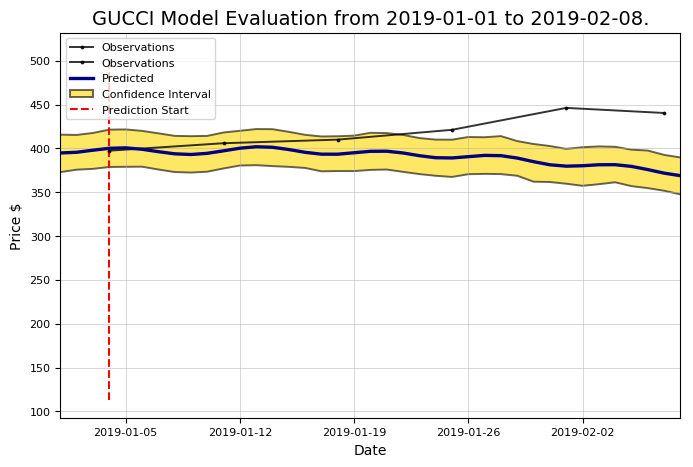

In [8]:
gucci.evaluate_prediction(start_date = "2019-01-01", end_date = "2019-02-08")

These predictions may not be very good! However, it is likely that the model hyperparameters (settings) are not optimized for our problem. There are a number of these knobs we can adjust to improve the model, with perhaps the most important the changepoint prior scale, or the amount of weight the model assigns to shifts in the data.

### 2.3 Changepoint Prior Scale Selection

Changepoints represent where a time series goes from increasing to decreasing or from increasing slowly to increasingly rapidly. They occur at the places with the greatest change in the rate of the time series.

The changepoint prior scale represents the amount of weight given to the changepoints in the model. This can be used to control overfitting vs underfitting. A higher prior will create a model with more flexibility and more emphasis on the changepoints. This can lead to overfitting because the model will closely follow the training data. Lowering the prior decreases the model flexibility which can cause the opposite problem underfitting. This occurs when our model does not follow the training data closely enough and fails to learn the underlying relationships.

#### 2.3.1 Graphically

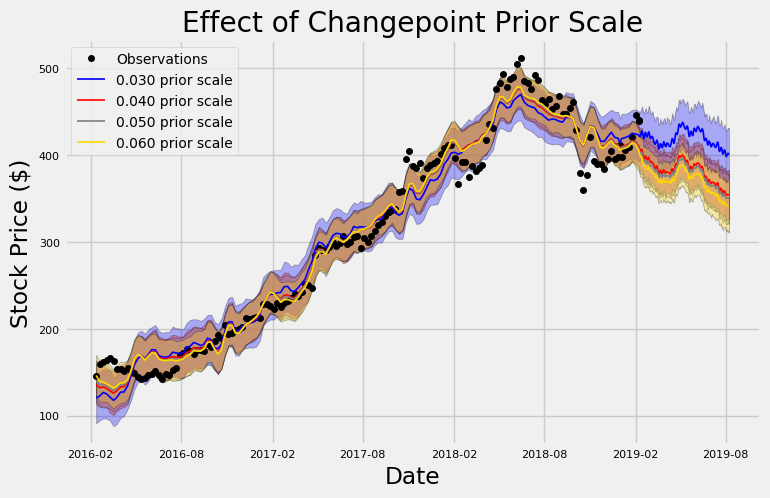

In [31]:
gucci.changepoint_prior_analysis(changepoint_priors=[0.03,0.04,0.05,0.06])


#### 2.3.2 Quantatively

This gives us an idea of how well each prior fits the training data, but no numbers to back up our intuitions. The changepoint prior validation method is designed to provide numerical backing.


Validation Range 2019-01-04 to 2019-02-07.

    cps  train_err  train_range   test_err  test_range
0  0.03  15.523577    48.879878  18.557334   48.697956
1  0.04  13.872600    43.457195  18.523111   43.563514
2  0.05  12.869446    41.127085  25.313652   42.022267
3  0.06  11.562998    37.579359  36.475507   37.841336


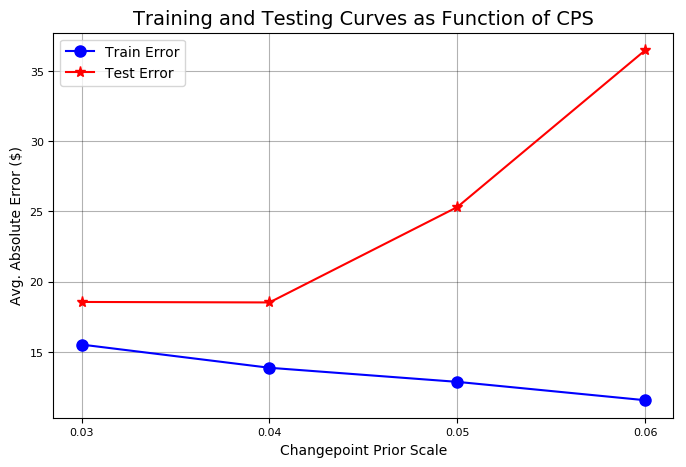

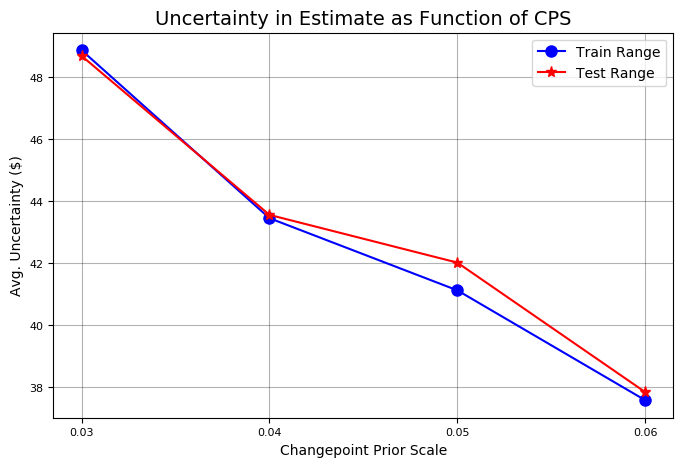

In [32]:
gucci.changepoint_prior_validation(start_date='2019-01-01', end_date='2019-02-08', changepoint_priors=[0.03,0.04,0.05,0.06])


We now assign the changepoint prior with the smallest error on the testing set to the Stocker object. The prior is one of the attiributes and we can change it like any other variable. At this point, we could also change the seasonalities or the amount of training data to achieve the best performance on the testing data



In [33]:
gucci.changepoint_prior_scale = 0.04


#### 2.4 Evaluate improved model


Prediction Range: 2019-01-01 to 2019-02-08.

Predicted price on 2019-12-31 = $311.88.
Actual price on    2019-02-07 = $440.40.

Average Absolute Error on Training Data = $13.87.
Average Absolute Error on Testing  Data = $25.02.

When the model predicted an increase, the price increased nan% of the time.
When the model predicted a  decrease, the price decreased  20.00% of the time.

The actual value was within the 80% confidence interval 66.67% of the time.
2019-01-01 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2019-02-08 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


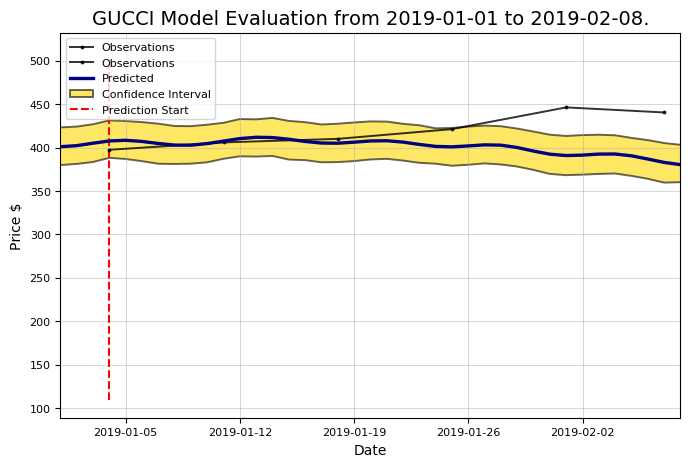

In [34]:
gucci.evaluate_prediction(start_date = "2019-01-01", end_date = "2019-02-08")

## 2.3 Other ideas to improve the model

Even if the Prophet model _works best with time series that have strong seasonal effects_ lot more things can be added to better forecast the time series. 
For instance [seasonnality, holidays and regressors](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html) : 
 - holidays and special events
 - how quickly the seasonality can change using `yearly_seasonality` based on Fourrier's series
 - specifying custom seasonalities with `.add_seasonality(name='your_seasonality', period=your_period, fourier_order=your_fo)`
 - adjust holidays and special events prior scale to smooth them using the parameter `holidays_prior_scale`
 - other regressors to the linear part of the model using the `add_regressor` method or function
 
Or [multiplicative seasonnality](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html) when the seasonnality grows with the trend. Or even the [uncertainety interval](https://facebook.github.io/prophet/docs/uncertainty_intervals.html).
